In [1]:
import numpy as np  
import scipy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
# ALL DATA READ INTO PANDAS DATAFRAME

df_indices = pd.read_csv("modified_datasets/indices", parse_dates=True, header=0, index_col=0)
df_sentiment = pd.read_csv("modified_datasets/sentiment", parse_dates=True, header=0, index_col=0)
df_stocks = pd.read_csv("modified_datasets/stock_info_all", parse_dates=True, header=0, index_col=0)

In [3]:
# CONVERTING TO LOG RETURNS

df_pre = pd.concat([df_stocks, df_indices],axis=1).dropna()

# LOG RETURNS FOR STOCK TICKS
prices = [k for k in df_pre.columns if 'close' in k]
mat = df_pre[prices].as_matrix()
matnew = np.zeros((len(mat)-1,len(mat[0])))
for i in xrange(len(matnew)):
    matnew[i] = np.divide(np.subtract(mat[i+1], mat[i]), mat[i])
matnew = np.log(1 + matnew)#, axis=0)

# LOG PCT CHANGES FOR VOLUME
vols = [k for k in df_pre.columns if 'volume' in k]
df_pre.ccgi_volume = df_pre.ccgi_volume.replace(0.0, 1.0)
matv = df_pre[vols].as_matrix()
matnewv = np.zeros((len(mat)-1,len(mat[0])))
for i in xrange(len(matnewv)):
    matnewv[i] = np.divide(np.subtract(matv[i+1], matv[i]), matv[i])
matnewv = np.log(1 + matnewv)

df_pre = df_pre.iloc[1:,]
df_pre = pd.concat([pd.DataFrame(matnewv, columns=vols, index=df_pre.index),
                    pd.DataFrame(matnew, columns=prices, index=df_pre.index)], axis=1)

df_pre = df_pre.iloc[4:]
df_pre = df_pre.reindex_axis(sorted(df_pre.columns), axis=1)
#df_sentiment = (df_sentiment - df_sentiment.min()) / (df_sentiment.max() - df_sentiment.min())

In [4]:
df1 = np.cumsum(df_pre[prices], axis=0)
df2 = df_pre[prices]

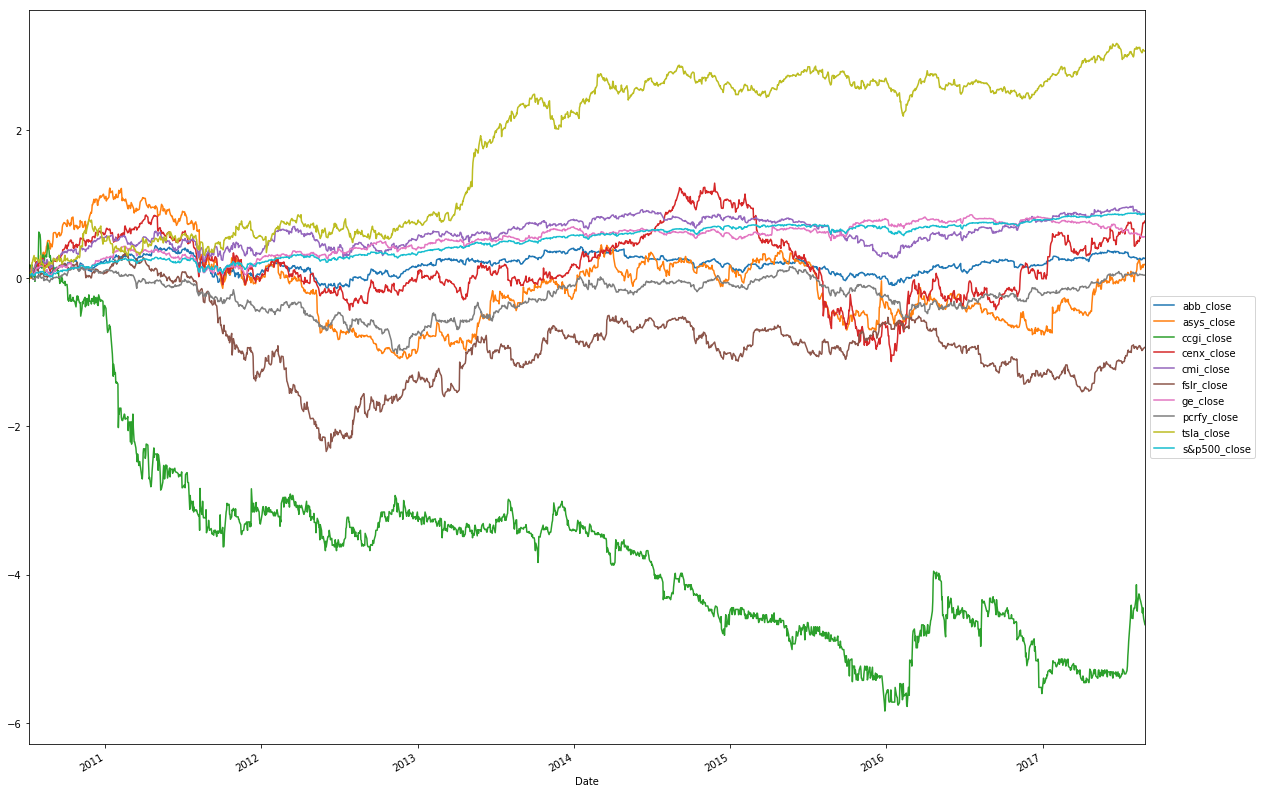

In [5]:
df1.plot(figsize=(20,15))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

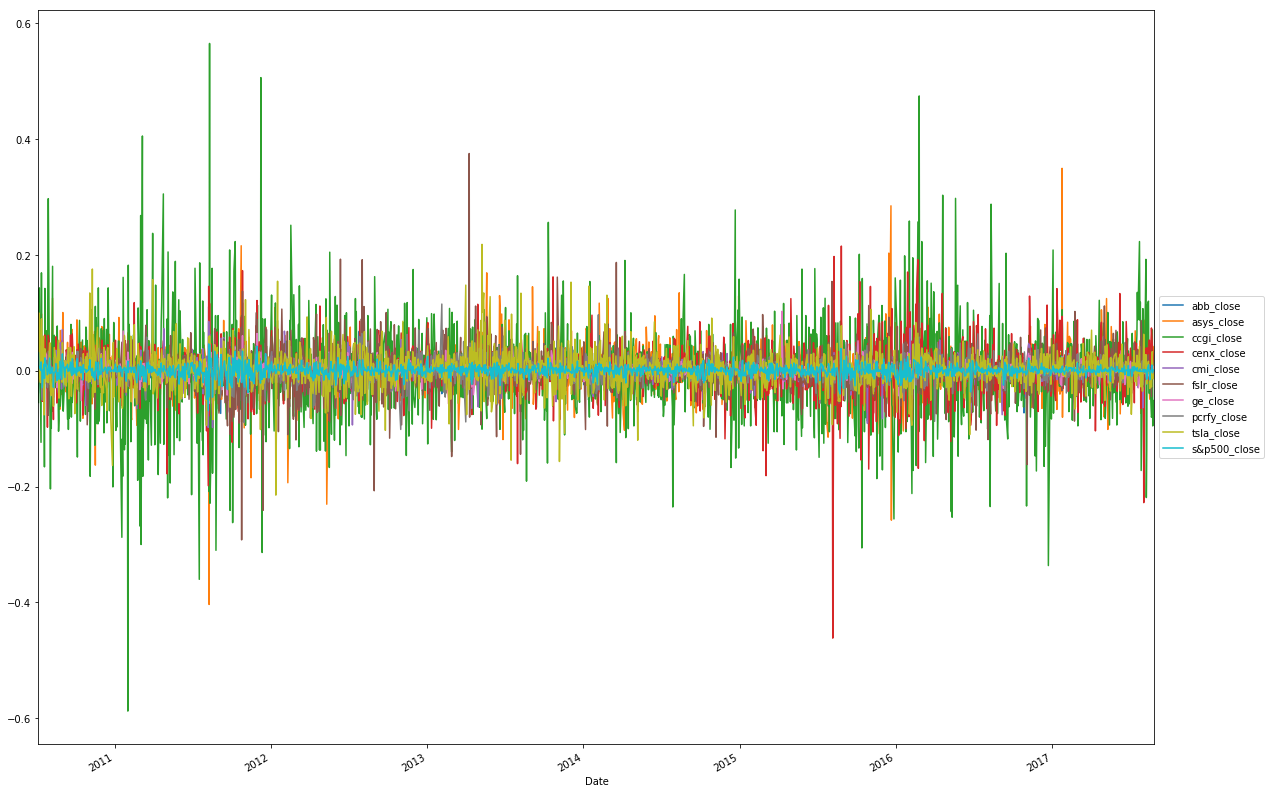

In [6]:
df2.plot(figsize=(20,15))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

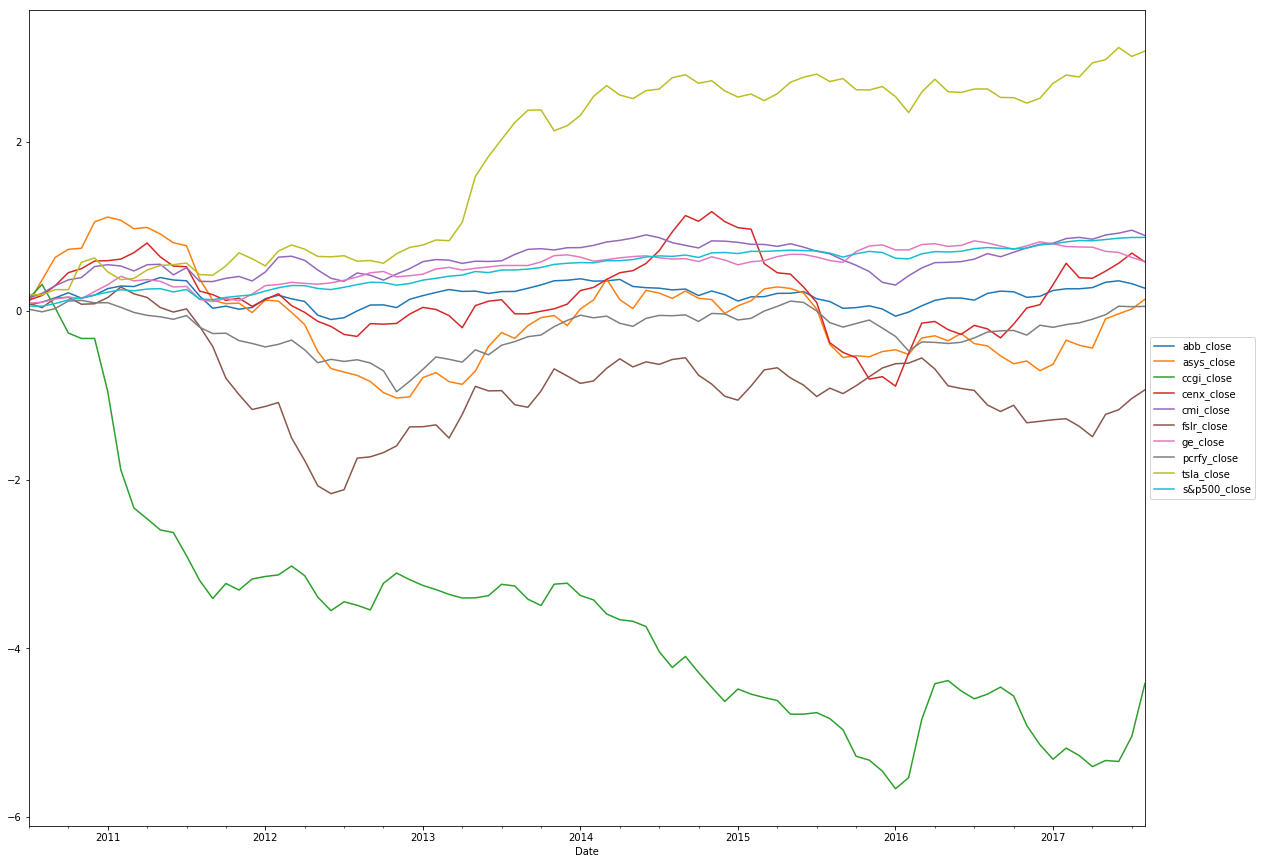

In [7]:
df1 = df1.resample('M').mean()
df1.plot(figsize=(20,15))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

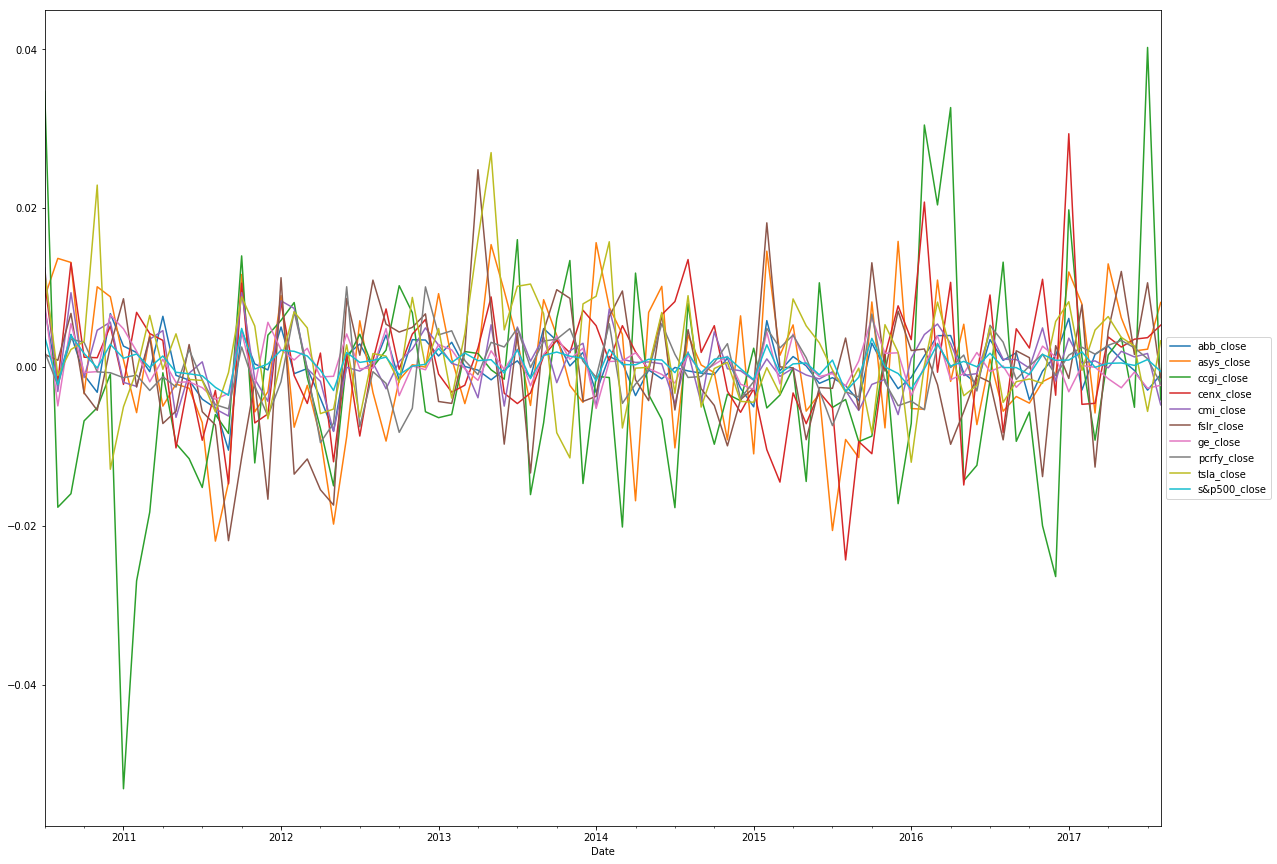

In [8]:
df2 = df2.resample('M').mean()
df2.plot(figsize=(20,15))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

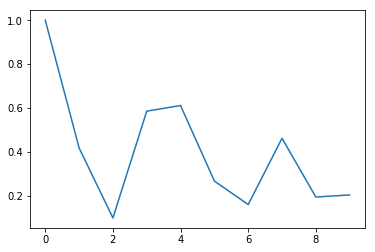

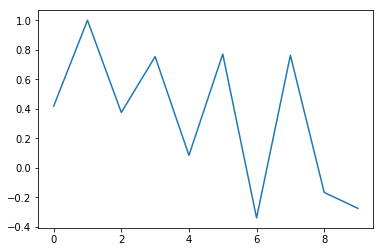

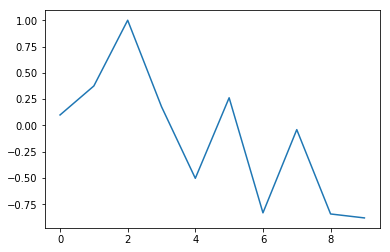

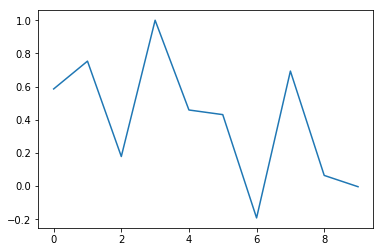

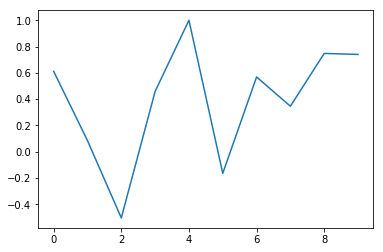

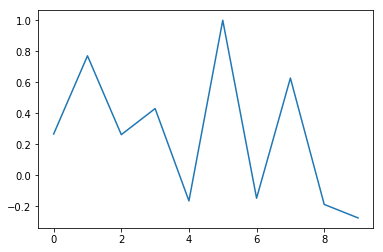

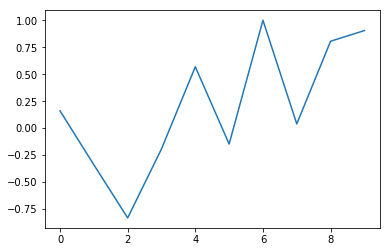

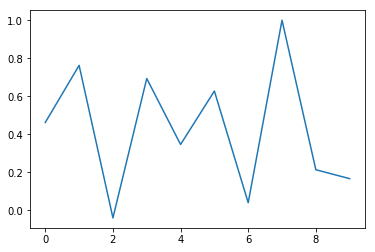

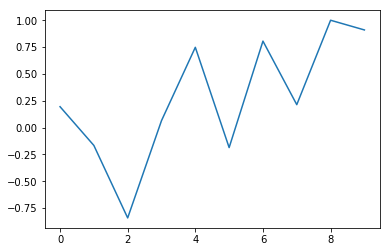

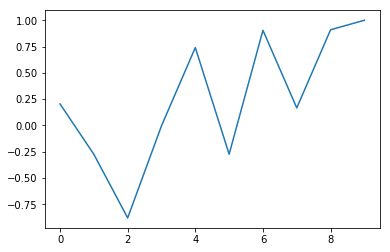

In [10]:
# COMPARING CORRELATIONS

from scipy.stats import spearmanr

rho1, pval = spearmanr(df1, axis=0)
for i in xrange(len(rho1[0])):
    plt.figure()
    plt.plot(np.arange(10),rho1[i])

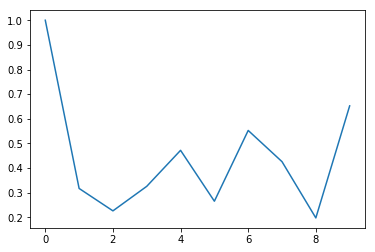

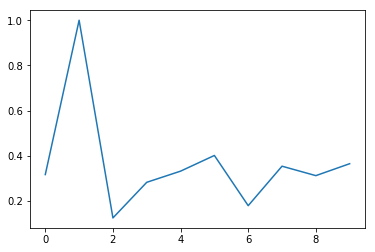

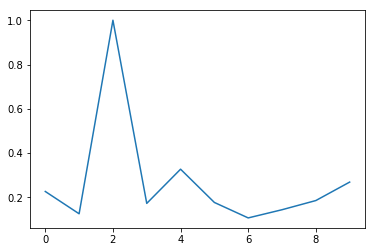

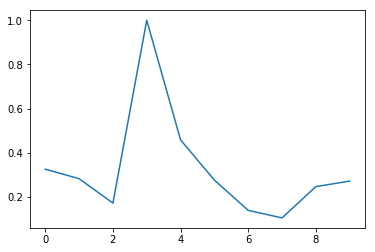

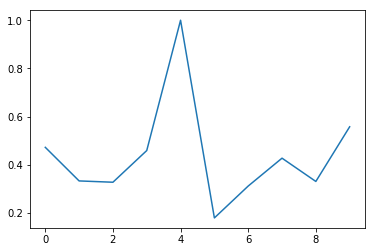

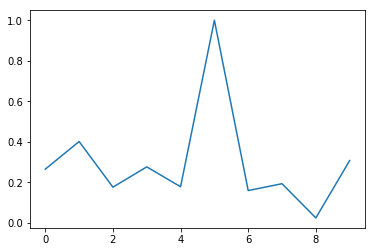

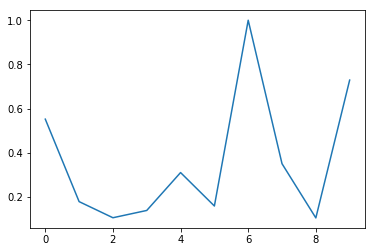

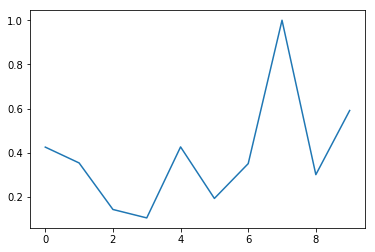

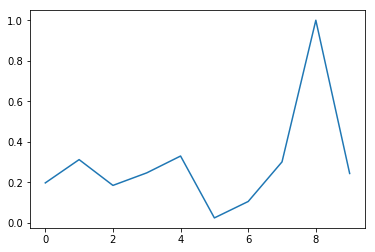

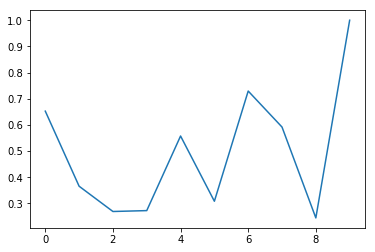

In [35]:
rho2, pval = spearmanr(df2, axis=0)
for i in xrange(len(rho2[0])):
    plt.figure()
    plt.plot(np.arange(10),rho2[i])

In [36]:
df1.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,abb_close,asys_close,ccgi_close,cenx_close,cmi_close,fslr_close,ge_close,pcrfy_close,tsla_close,s&p500_close
abb_close,1.0,0.42,0.099,0.59,0.61,0.27,0.16,0.46,0.19,0.2
asys_close,0.42,1.0,0.38,0.75,0.085,0.77,-0.34,0.76,-0.17,-0.28
ccgi_close,0.099,0.38,1.0,0.18,-0.5,0.26,-0.83,-0.04,-0.84,-0.88
cenx_close,0.59,0.75,0.18,1.0,0.46,0.43,-0.19,0.69,0.064,-0.0041
cmi_close,0.61,0.085,-0.5,0.46,1.0,-0.16,0.57,0.35,0.75,0.74
fslr_close,0.27,0.77,0.26,0.43,-0.16,1.0,-0.15,0.63,-0.19,-0.27
ge_close,0.16,-0.34,-0.83,-0.19,0.57,-0.15,1.0,0.039,0.81,0.9
pcrfy_close,0.46,0.76,-0.04,0.69,0.35,0.63,0.039,1.0,0.21,0.17
tsla_close,0.19,-0.17,-0.84,0.064,0.75,-0.19,0.81,0.21,1.0,0.91
s&p500_close,0.2,-0.28,-0.88,-0.0041,0.74,-0.27,0.9,0.17,0.91,1.0


In [37]:
df2.corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

,abb_close,asys_close,ccgi_close,cenx_close,cmi_close,fslr_close,ge_close,pcrfy_close,tsla_close,s&p500_close
abb_close,1.0,0.32,0.23,0.33,0.47,0.27,0.55,0.43,0.2,0.65
asys_close,0.32,1.0,0.13,0.28,0.33,0.4,0.18,0.35,0.31,0.37
ccgi_close,0.23,0.13,1.0,0.17,0.33,0.18,0.11,0.14,0.19,0.27
cenx_close,0.33,0.28,0.17,1.0,0.46,0.28,0.14,0.11,0.25,0.27
cmi_close,0.47,0.33,0.33,0.46,1.0,0.18,0.31,0.43,0.33,0.56
fslr_close,0.27,0.4,0.18,0.28,0.18,1.0,0.16,0.19,0.025,0.31
ge_close,0.55,0.18,0.11,0.14,0.31,0.16,1.0,0.35,0.11,0.73
pcrfy_close,0.43,0.35,0.14,0.11,0.43,0.19,0.35,1.0,0.3,0.59
tsla_close,0.2,0.31,0.19,0.25,0.33,0.025,0.11,0.3,1.0,0.24
s&p500_close,0.65,0.37,0.27,0.27,0.56,0.31,0.73,0.59,0.24,1.0


In [177]:
from statsmodels.tsa.stattools import grangercausalitytests
from pandas.core import datetools
import itertools

dfg = df2.as_matrix()
#res = grangercausalitytests(dff[:,:2],27,verbose=False)
r = list(map("".join, itertools.permutations('0123456789',2)))
results = []
depends = []

for i in range(len(r)):
    c1 = int(r[i][0])
    c2 = int(r[i][1])
    res = grangercausalitytests(dfg[:,[c1,c2]],27,verbose=False) # try with smaller lag values
    f = {}
    p = {}
    for key, val in res.items():
        if val[0]['ssr_ftest'][1] < 0.05:
            f[key] = val[0]['ssr_ftest'][1]
            p[r[i]] = val[0]['ssr_ftest'][1]
            
    if len(f)!=0:
        results.append(f)
        depends.append(p)

In [186]:
#dependencies = np.zeros((10,10))
for c in results:
    print c
edges = []
for d in depends:
    for k,v in d.items():
        edges.append(k)
        print k,v

{18: 0.031699089559599304, 19: 0.016196994530133756, 20: 0.025708881589828446}
{24: 0.033306733061214767}
{17: 0.0068658239012316215, 18: 0.011942014900086216}
{25: 0.015938209657843479}
{2: 0.023088338567002729}
{1: 0.0015276759039760555, 2: 0.0074338012073946339, 3: 0.0008050663959123526, 4: 0.0017820646147100245, 5: 0.0074974846682003653, 6: 0.0029401272036415041, 7: 0.0029946314981281917, 8: 0.0018196870348218415, 9: 0.0040288382060570064, 10: 0.0094483060523824908, 11: 0.018612103935412374, 12: 0.031139039908274463, 13: 0.033049108904875397, 16: 0.026305074167591511, 17: 0.027074157009716254, 18: 0.04431937523140498}
{22: 0.024181591401235217, 23: 0.033611442070839298}
{17: 0.01997627377291928, 18: 0.039668770536322742}
{1: 0.041973953200406214}
{24: 0.045012710722499447}
{1: 0.028083772393740967}
{2: 0.036395636375021932}
{19: 0.042979025336570095}
{7: 0.0096489426679718399, 8: 0.02651646096095767, 9: 0.035561207854829927, 10: 0.020957317635705425, 11: 0.044322970314017739, 12: 0

In [180]:
import networkx as nx
G=nx.DiGraph()
G.add_nodes_from([0,1,2,3,4,5,6,7,8,9])
for d in edges:
    G.add_edge(int(d[0]),int(d[1]))

(-1.1978104623493084,
 1.081719627580817,
 -1.1225538501527557,
 0.90266929289829079)

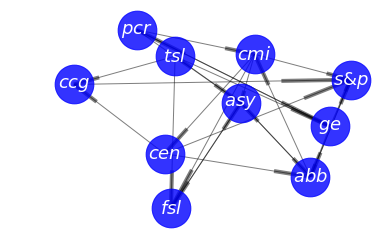

In [261]:
#nx.draw(G)
pos = nx.spring_layout(G,k=1,iterations=20)
nx.draw_networkx_nodes(G,pos,nodelist=[0,1,2,3,4,5,6,7,8,9],node_color='b',node_size=1500,alpha=0.8)
nx.draw_networkx_edges(G,pos,width=1.0,alpha=0.5)

labels={}
labels[0]=r'$abb$'
labels[1]=r'$asy$'
labels[2]=r'$ccg$'
labels[3]=r'$cen$'
labels[4]=r'$cmi$'
labels[5]=r'$fsl$'
labels[6]=r'$ge$'
labels[7]=r'$pcr$'
labels[8]=r'$tsl$'
labels[9]=r'$s&p$'
nx.draw_networkx_labels(G,pos,labels,font_size=18,font_color='white')

plt.axis('off')

In [200]:
# PREP DATA FOR ML

# Sliding Window

def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [293]:
training = np.cumsum(df_pre[['cmi_close','abb_close','pcrfy_close']],axis=0).as_matrix()
abb = rolling_window(training[:,1],24)[3:]
pcr = rolling_window(training[:,2],27)
x = 6 # 1 week look-back
cmi = rolling_window(training[:,0],x)[21:]
labels = cmi[:,-1:]
cmi = cmi[:,:-1]
data = np.concatenate((cmi,np.concatenate((abb,pcr),axis=1)),axis=1)

train_x = data[:1420]
test_x = data[1420:]
train_y = labels[:1420]
test_y = labels[1420:]

#print train_x.shape, test_x.shape, train_y.shape, test_y.shape
print test_y.min(), test_y.max()

0.502675426867 0.9712268674


In [294]:
# IMPLEMENTING SVM FOR CMI

from sklearn.svm import SVR
from sklearn.metrics import f1_score, confusion_matrix, mean_squared_error

def acc(test_y, pred):
    print mean_squared_error(test_y, pred)
    #f1 = f1_score(test_y, pred, average='weighted')
    #print f1
    #conf_mat = confusion_matrix(test_y, pred)
    #print ""
    #print "Confusion Matrix"
    #print conf_mat

svr_rbf = SVR(kernel='rbf', C=1e5, gamma=0.001)
y_rbf = svr_rbf.fit(train_x, train_y).predict(test_x)
acc(test_y,y_rbf)

svr_lin = SVR(kernel='linear', C=1e2)
y_lin = svr_lin.fit(train_x, train_y).predict(test_x)
acc(test_y,y_lin)

svr_poly = SVR(kernel='poly', C=1e5, degree=2)
y_poly = svr_poly.fit(train_x, train_y).predict(test_x)
acc(test_y,y_poly)

0.00217852268879
0.00216645913063
0.0032382208826


In [295]:
print 0.00217852268879/0.502675426867
print 0.00353820144993/0.502675426867

print (0.00703873963361-0.00433385555043)/0.00433385555043

0.00433385555043
0.00703873963361
0.624128804411


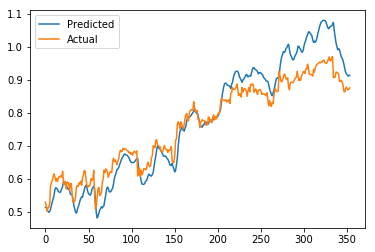

In [296]:
plt.plot(range(354),y_poly,label='Predicted')
plt.plot(range(354),test_y,label='Actual')
plt.legend()

In [287]:
cmi = rolling_window(training[:,0],21)
labels = cmi[:,-1:]
data = cmi[:,:-1]

train_x = data[:1420]
test_x = data[1420:]
train_y = labels[:1420]
test_y = labels[1420:]

print train_x.shape, test_x.shape, train_y.shape, test_y.shape
print test_y.min(), test_y.max()

(1420, 19) (361, 19) (1420, 1) (361, 1)
0.502675426867 0.9712268674


In [288]:
svr_rbf = SVR(kernel='rbf', C=1e5, gamma=0.001)
y_rbf = svr_rbf.fit(train_x, train_y).predict(test_x)
acc(test_y,y_rbf)

svr_lin = SVR(kernel='linear', C=1e2)
y_lin = svr_lin.fit(train_x, train_y).predict(test_x)
acc(test_y,y_lin)

svr_poly = SVR(kernel='poly', C=1e5, degree=2)
y_poly = svr_poly.fit(train_x, train_y).predict(test_x)
acc(test_y,y_poly)

0.00169931067167
0.00172964787637
0.00353820144993


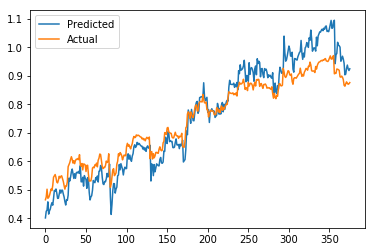

In [285]:
plt.plot(range(376),y_poly,label='Predicted')
plt.plot(range(376),test_y,label='Actual')
plt.legend()